First, we import the necessary packages and load our data into a dataframe. 

In [15]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm

filepath = '/Users/gracemcmonagle/Desktop/School/Fall 2020/EECS 731/Project 2/1028_2124_bundle_archive/Shakespeare_data.csv'
rawData = pd.read_csv(filepath, delimiter = ',')

We examine the data and notice that there are entries like "Act 1" and "Scene 1" that do not have player line entry. We wish to remove those. 

In [3]:
data = rawData.dropna()

Next, I was interested to see how many different players there were, so I created a list of the different players.

In [4]:
players = data.Player.unique().tolist()
print(len(players))

934


Here is where my next two approaches diverged a bit. I originally one-hot encoded the plays and attempted to run the classifiers on this dataset. This increased the accuracy a bit from my original attempt, however, it was only in the 20 percent range which I wasn't happy with. I then decided to run the classifiers on separate datasets based on the play, limiting the number of possible players. So, I created a list of the unique plays here. 

In [5]:
plays = data.Play.unique().tolist()

I also decided to utilize the act/scene/line variable by splitting it at the period and creating three separate columns. 

In [6]:
for index, row in data.iterrows():
    data['ActSceneLine'][index] = data['ActSceneLine'][index].split('.')
        
act = []
scene = []
line = []
for index, row  in data.iterrows():
    act.append(data['ActSceneLine'][index][0])
    scene.append(data['ActSceneLine'][index][1])
    line.append(data['ActSceneLine'][index][2])
    
data['Act'] = act
data['Scene'] = scene
data['Line'] = line

/Users/gracemcmonagle/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/gracemcmonagle/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/gracemcmonagle/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.py

We now move onto feature engineering. The first feature we're interested in adding is a column to indicate the length of the line. 

In [8]:
noWords = []
for index, row in data.iterrows():
    noWords.append(len(row['PlayerLine'].split()))
    
data['NumWords'] = noWords

/Users/gracemcmonagle/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Next, we are interested in creating new columns to indicate whether popular words are included in the line. To do so, we will count the instances of all the words and take the 50 most used ones. Then, we create a new variable for each of these 20 words with a count of that word for the given line. 

In [7]:
wordCount = {}
for index, row in data.iterrows():
    line = row['PlayerLine'].translate(str.maketrans('', '', string.punctuation)).lower()
    words = line.split()
    for word in words:
        if word not in wordCount:
            wordCount[word] = 0
        wordCount[word] += 1
        
sorted_wordCount = sorted(wordCount.items(), key=lambda x: x[1], reverse=True)
#top 20 words
top_words20 = sorted_wordCount[:50]

To get a sense of the top 20 words, we create a bar chart with the top 50 words and their instances:

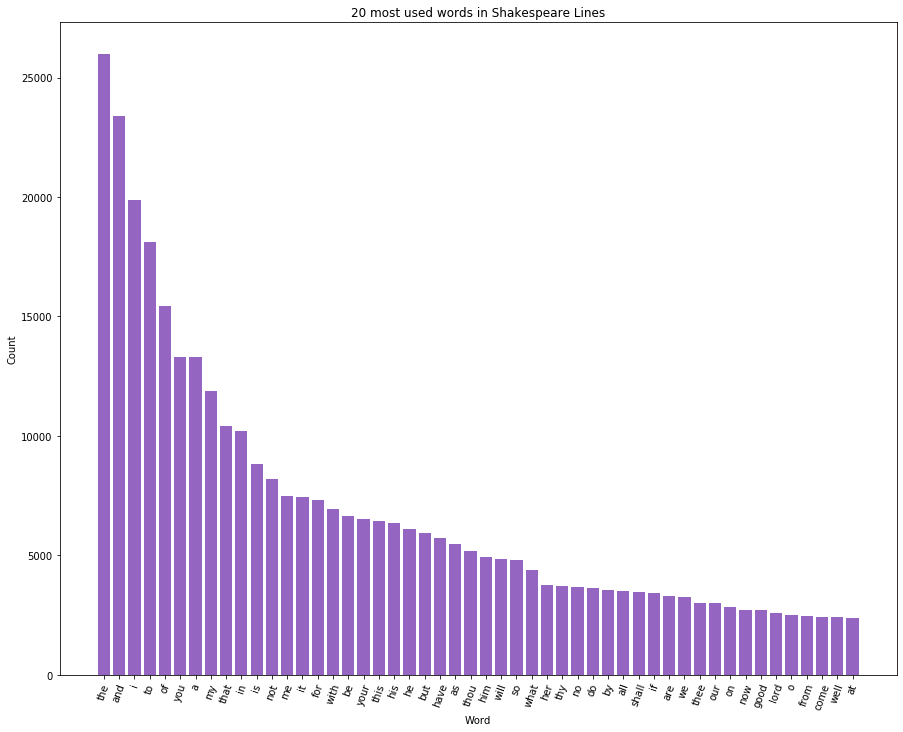

In [12]:
plt.figure(figsize=(15,12))
plt.bar(range(len(top_words20)), [val[1] for val in top_words20], align='center', color=(0.3, 0.0, 0.6, 0.6))
plt.xticks(range(len(top_words20)), [val[0] for val in top_words20])
plt.xticks(rotation=70)
plt.xlabel('Word')
plt.ylabel('Count')
plt.title('20 most used words in Shakespeare Lines')
plt.draw()

As we said, we want to create a new column in our dataframe for each of these words to count the instances of the word in the given line.

In [18]:
columns = {}
for word in top_words50:
    columns[word[0]] = [0 for _ in range(len(noWords))]

i=0   
for index, row in data.iterrows():
    line = row['PlayerLine'].translate(str.maketrans('', '', string.punctuation)).lower()
    words = line.split()
    for word in words:
        if word in columns:
            columns[word][i] += 1
    i+=1
    
for word in top_words50:
    data[word[0] + '_count'] = columns[word[0]]

/Users/gracemcmonagle/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


Now that we have the data prepared in a way that we want to run through a classifier, we are going to separate the data by the play by creating a dictionary with the key as the play and the entry as the dataframe we will run through the classifier.

In [13]:
dataPlays = {elem: pd.DataFrame for elem in plays}
for key in dataPlays.keys():
    dataPlays[key] = data[:][data.Play == key]

We will now run a Logistic Regression classifier and a SVC classifier. We'll keep track of the accuracy of each play and we can take the average over all the plays to get an accuracy for the whole dataset.

In [16]:
svcScore = []   
lrScore = [] 
for key in dataPlays.keys():
    labels = dataPlays[key]['Player']   
    data_x = dataPlays[key].drop(['Player', 'Dataline','ActSceneLine', 'PlayerLine', 'Play'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(data_x, labels, test_size=0.2, random_state=0)
    classifier = LogisticRegression(multi_class = 'auto', solver = 'liblinear')
    classifier.fit(X_train,y_train)
    score = classifier.score(X_test, y_test)
    lrScore.append(score)
    clf = svm.SVC(gamma = 'auto')
    clf.fit(X_train, y_train)
    scoreSVC = clf.score(X_test, y_test)
    svcScore.append(scoreSVC)

In [17]:
print("LR Accuracy:")
print(sum(lrScore)/len(lrScore))

LR Accuracy:
0.3109863417045473


In [18]:
print("SVC Accuracy:")
print(sum(svcScore)/len(svcScore))

SVC Accuracy:
0.6867100390443183
